<a href="https://colab.research.google.com/github/Anita-P-B/start-here-guidelines/blob/master/09_SkimLit_nlp_milestome_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose of this project is to make reading medical scientific paper abstract easier by breaking the abstract into seveal sections:
-Objective
-Backgrpund
-Methods
-Results
-Conculsions/Summary
Each sentence in the abstract will classified for one of the sections abouve.

The source of the dataset can be view in the link below:

https://arxiv.org/abs/1710.06071

The model architecture we will be using availible here:

https://arxiv.org/abs/1612.05251

In [ ]:
# Check GPU
!nvidia-smi

Thu Mar 24 11:21:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |   1897MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the directory 'PubMed_20K_RCT'
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt


* dev sometimed means 'validation'- another term for validation set

In [ ]:
# Start the experiments using the 20K dataset with numbers replaces by @
data_dir='/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

# Check the file names in the target directory
import os
filenames=[data_dir+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [ ]:
filenames[0]

'/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt'

In [ ]:
with open(filenames[0]) as test_raw:
    lines = test_raw.readlines()
test_raw.close()
lines[:10]

['###24845963\n',
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n',
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n',
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n',
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n',
 "RESULTS\tThe percentage of patients with abnormal LFTs decreased significantly from baseline to @-months ' follow-up .\n",
 'RE

In [ ]:
# Create a function to read the lines of a document
def get_lines(filename):
  '''
  Raeds filename (a txt. file) and returns the lines of the file as a list.

  Args:
    filename- a string containing the filepath
  Returns:
    A list of string contains one string per line from target filename. 
  '''
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
# Read in the trainng lines 
train_lines=get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

How the data should look like?

It can be represented by a list of dictionaires like this:

```
[{"line_number': 0,
  'target': BACKGORUND',
  'text': 'Emotional eating is associated with overeating and the development of obesity'
  'total_lines': 11},
  ....]
```

In [ ]:
train_lines[0].startswith('###')
abstract_line_split=train_lines[13].isspace()
abstract_line_split
n=train_lines[1].split("\t")
n[1]

'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n'

In [ ]:
# Create a preprocessing function that can read in the text as the format above
def preprocess_text_with_line_numbers(filename):
  '''
  Returns a list of dictionaries of abstract liens of data.
  Reads 'filename', reads it's content and sorts through each line, extracting:
  - the target label
  - the text sentence
  - the line number
  - total number of line in the abstract
  Args: 
    `filename' (str)
  Returns:
     A list of dictionaries sorted as described above.  
  '''
  input_lines=get_lines(filename)
  abstract_lines="" # Creates an empty abstract
  abstract_samples=[] # Creates an empty list of abstracts

  # Loop through each line in the target file 
  for line in input_lines:
    if line.startswith('###'):
      absract_id=line
      abstract_lines="" # reset the abstract string
    elif line.isspace(): # Check to see if a line is a new line
      abstract_line_split=abstract_lines.splitlines() # split abstract into separate lines 

      # Iterate through each line in a single abstrct and count them at the same time 
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data={} # Create an empty dictionary for each line
        target_text_split=abstract_line.split("\t")
        line_data["target"]=target_text_split[0]
        line_data["text"]=target_text_split[1].lower() # Convert all the sentence to lower case
        line_data["line_number"]=abstract_line_number
        line_data["total_lines"]=len(abstract_line_split)-1
        abstract_samples.append(line_data)
    else: # If the above conditions aren't fulfilled, the lien contains a labeled sentence
      abstract_lines+=line
  return abstract_samples





In [ ]:

train_samples=preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples=preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples=preprocess_text_with_line_numbers(data_dir+"test.txt")

len(train_samples), len(val_samples), len(test_samples)


(180040, 30212, 30135)

In [ ]:
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
# Turn the preprocess data into a DataFrame
import pandas as pd 
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
# distribution of labels in the training data
train_df.value_counts("target")

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
dtype: int64

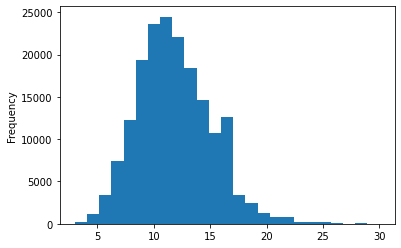

In [ ]:
# Chack the length of different abstracts
train_df.total_lines.plot.hist(bins=25)

### Get lists of sentences


In [ ]:
# Convert abstract text lines into lists
train_sentences=train_df.text.tolist()
val_sentences=val_df.text.tolist()
test_sentences=test_df.text.tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

## Convert labels into numeric form

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse=False) # we want a non spars matrix
train_labels_one_hot=one_hot_encoder.fit_transform(train_df.target.to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.transform(val_df.target.to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.transform(test_df.target.to_numpy().reshape(-1,1))

test_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

### Label encode labels 

In [ ]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df.target.to_numpy())
val_labels_encoded=label_encoder.transform(val_df.target.to_numpy())
test_labels_encoded=label_encoder.transform(test_df.target.to_numpy())


In [ ]:
# Get class names and number of classes from LabelENcoder
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
class_names


array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

# Starting a series of modeling experiments

## Baseline model- Naive-Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0=Pipeline([("tf-idf", TfidfVectorizer()), # convert sentences into numbers
                 ("clf",MultinomialNB())])


# Fit the model

model_0.fit(train_sentences,train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model 0
model_0.score(val_sentences,val_labels_encoded) 

0.7218323844829869

In [ ]:
# Make predictions using the baseline model
model_0_preds=model_0.predict(val_sentences)

In [ ]:
model_0_preds.shape

(30212,)

### Download helper_functions script

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-24 11:21:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-24 11:21:18 (67.9 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results
baseline_results=calculate_results(val_labels_encoded, model_0_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

# Prepraring the text for deep learning models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# What is the average sentence length?
sent_length=[len(sentence.split()) for sentence in train_sentences]
av_sent_length=np.mean(sent_length)
med_sent_length=np.median(sent_length)
av_sent_length,med_sent_length

(26.338269273494777, 23.0)

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

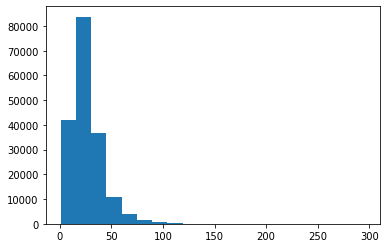

In [ ]:
# Sentence length distribution
import matplotlib.pyplot as plt
plt.hist(sent_length, bins=20)

In [ ]:
# What sentence length covers 95% of examples?
output_sec_length=int(np.percentile(a=sent_length,q=95))
output_sec_length

55

In [ ]:
# Max sentenc elength in training data
np.max(sent_length)

296

### Create text vectorizer layer

In [ ]:
from pandas.core.internals.managers import T
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_tokens=68000
text_vectorizer=TextVectorization(max_tokens=max_tokens, # Number of words in vocabulary
                                  output_sequence_length=output_sec_length # desired output length of vecotrized sequences
)



In [ ]:
# Fit text_vactorizer on training data
text_vectorizer.adapt(train_sentences)

In [ ]:
# test text vectorizer on random sentences 
import random
target_sentence=random.choice(test_sentences)
print(f"Text:\n {target_sentence}")
print(f"sentence length:\n {len(target_sentence)}")
print(f"Vectorized text: \n{text_vectorizer([target_sentence])}")

Text:
 before , at completion of training , and six-weeks later , patients underwent constant-load treadmill testing .
sentence length:
 111
Vectorized text: 
[[  129    15  1028     4   155     3 28501   869    12   352 27033  3185
    574     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
text_vectorizer([target_sentence]).shape

TensorShape([1, 55])

In [ ]:
rct_20k_text_vocab=text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}")
print(f"5 most common word in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"5 least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
5 most common word in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
5 least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of the text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization_1',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### create custom text embedding

In [ ]:
# Create token embedding layer

token_embed=layers.Embedding(input_dim=len(rct_20k_text_vocab),
                             output_dim=128,
                             mask_zero=True, # Use masking to handle variables with varying lengths
                             name="token_embeddings")

In [ ]:
# Test the embedding 
print(f"sample sentence:\n {target_sentence}")
print(f"sentence after vactorization:\n {text_vectorizer(target_sentence)}")
print(f"sentence after embedding:\n {token_embed(text_vectorizer(target_sentence))}")

sample sentence:
 before , at completion of training , and six-weeks later , patients underwent constant-load treadmill testing .
sentence after vactorization:
 [  129    15  1028     4   155     3 28501   869    12   352 27033  3185
   574     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]
sentence after embedding:
 [[-0.02034399 -0.02338203 -0.00095612 ...  0.04337334 -0.04693153
  -0.0313414 ]
 [-0.01506098  0.04208383  0.03253109 ... -0.04720182  0.02790398
   0.02383694]
 [-0.00807758 -0.03611281  0.04534253 ...  0.03595454  0.04885625
   0.00610904]
 ...
 [ 0.04677084 -0.04268114  0.01947179 ...  0.02493681  0.04581641
  -0.01138889]
 [ 0.04677084 -0.04268114  0.01947179 ...  0.02493681  0.04581641
  -0.01138889]
 [ 0.04677084 -0.04268114  0.01947179 ...  0.02493681  0.04581641


## Creating datasets (making sure the data loads as fast as possible)

This will be achieved by using tf.data API


In [ ]:
# Turn the data into TensorFlow Datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
valid_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Convert TensorFlow slices Datasets into prefetched datasets
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 
valid_dataset=valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Modle 1: Conv1D with token embeddings

In [ ]:
# create 1D Conv model to precess sequences
inputs=layers.Input(shape=(1,),dtype="string")
text_vectors=text_vectorizer(inputs)
token_embeddings=token_embed(text_vectors)

x=layers.Conv1D(filters=64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x=layers.GlobalAveragePooling1D()(x)

outputs=layers.Dense(num_classes,activation="softmax")(x)

model_1=tf.keras.Model(inputs, outputs)

model_1.summary()

# Compile the model
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=["accuracy"])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embeddings (Embedding  (None, 55, 128)          8299648   
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                           

In [ ]:
# Fit the model
history_1=model_1.fit(train_dataset,
            epochs=3,
            validation_data=(valid_dataset),
            steps_per_epoch=int(0.1*len(train_dataset)),
            validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 0.9224 - accuracy: 0.6367 - val_loss: 0.6844 - val_accuracy: 0.7424
Epoch 2/3
562/562 [==============================] - 4s 6ms/step - loss: 0.6537 - accuracy: 0.7597 - val_loss: 0.6255 - val_accuracy: 0.7743
Epoch 3/3
562/562 [==============================] - 4s 6ms/step - loss: 0.6134 - accuracy: 0.7777 - val_loss: 0.5941 - val_accuracy: 0.7849


In [ ]:
# Evaluate on full validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5946 - accuracy: 0.7882


[0.5946372747421265, 0.7881636619567871]

In [ ]:
# Make precistions
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_pred_probs[:2]

array([[0.44308648, 0.16566141, 0.07789443, 0.28565988, 0.02769786],
       [0.4347761 , 0.29772416, 0.01151454, 0.24701849, 0.00896673]],
      dtype=float32)

In [ ]:
# Convert pred probs into class names
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)

In [ ]:
# Calculate model 1 results
results_1=calculate_results(val_labels_encoded,model_1_preds)
results_1

{'accuracy': 78.81636435853304,
 'f1': 0.785744366989453,
 'precision': 0.7853349022389168,
 'recall': 0.7881636435853303}

## Model 2: Feature extraction with pretrained token embeddings

Link to the pretrained model that will be utilized:

https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
# Download tensorflow hub model USE 
import tensorflow_hub as hub 
tf_hub_embedding_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                      trainable=False,
                                    
                                      name="universal_sentence_encoder")

In [ ]:
# Test out the embedding layer on a random sentence 
random_training_sentence=random.choice(train_sentences)
use_embedded_sentence=tf_hub_embedding_layer([random_training_sentence])
use_embedded_sentence[0][:30], use_embedded_sentence.shape

(<tf.Tensor: shape=(30,), dtype=float32, numpy=
 array([-0.05564841,  0.06016573,  0.00609033,  0.01266354, -0.04375385,
        -0.00211319,  0.05231209, -0.05568447,  0.02722036, -0.04395305,
         0.08709031,  0.03476335, -0.00704569, -0.02487821, -0.02119919,
         0.06275437, -0.08819257, -0.00320785, -0.04916652, -0.05051882,
        -0.05915193, -0.01531579,  0.00550297, -0.07153467,  0.0633248 ,
         0.01813931, -0.02139189,  0.00379695,  0.05909523, -0.05295375],
       dtype=float32)>, TensorShape([1, 512]))

### Building and fitiing model 2

In [ ]:
# Build model 2- feature extraction model
inputs=layers.Input(shape=[],dtype=tf.string)


pretrained_embedding=tf_hub_embedding_layer(inputs)
x=layers.Dense(128,activation="relu")(pretrained_embedding)

outputs=layers.Dense(len(class_names), activation="softmax")(x)

model_2=tf.keras.Model(inputs,outputs, name="model_2_USE_feature_extractor")

model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_18 (Dense)            (None, 128)               65664     
                                                                 
 dense_19 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit model 2 to the data
history_2=model_2.fit(train_dataset,
                      epochs=3,
                      steps_per_epoch=int(0.1*len(train_dataset)),
                      validation_data=(valid_dataset),
                      validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9176 - accuracy: 0.6475 - val_loss: 0.7957 - val_accuracy: 0.6885
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7681 - accuracy: 0.7023 - val_loss: 0.7544 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7517 - accuracy: 0.7124 - val_loss: 0.7375 - val_accuracy: 0.7134


In [ ]:
# Evaluate the model
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7404 - accuracy: 0.7140


[0.7404080033302307, 0.713954746723175]

In [ ]:
# make predictions using model 2
model_2_pred_probs=model_2.predict(valid_dataset)
model_2_pred_probs[:2]

array([[0.4359086 , 0.3561735 , 0.00223592, 0.19877996, 0.00690202],
       [0.36552683, 0.47599718, 0.00366293, 0.15213102, 0.00268207]],
      dtype=float32)

In [ ]:
# Conver the predictions into encoded labels
model_2_preds=tf.argmax(model_2_pred_probs, axis=1)
model_2_preds[:3], val_labels_encoded[:3]

(<tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 1, 3])>,
 array([0, 0, 3]))

In [ ]:
# compare the results
results_2=calculate_results(val_labels_encoded, model_2_preds)
results_2

{'accuracy': 71.39547199788163,
 'f1': 0.7110356087736287,
 'precision': 0.713929969494264,
 'recall': 0.7139547199788163}

In [ ]:
def compare_results(model, val_data=valid_dataset,val_labels=val_labels_encoded):
  '''
  Shows the results of a given model.
  '''
  print(model.evaluate(val_data))
  model_pred_probs=model.predict(val_data)
  model_preds=tf.argmax(model_pred_probs, axis=1)
  model_results=calculate_results(val_labels,model_preds)
  print(model_results)
  return model_results


In [ ]:
compare_results(model_2)

945/945 [==============================] - 12s 13ms/step - loss: 0.7404 - accuracy: 0.7140
[0.7404080033302307, 0.713954746723175]
{'accuracy': 71.39547199788163, 'precision': 0.713929969494264, 'recall': 0.7139547199788163, 'f1': 0.7110356087736287}


## Model 3: Conv1D with character embeddings

### Create a character-level tokenizer

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Chack the splitting function
split_chars(random_training_sentence)

'i n f o r m a t i o n   f r o m   @   v i s i t s   o f   @   p a t i e n t s   a g e d   a t   l e a s t   @   y e a r s   b e i n g   t r e a t e d   f o r   h y p e r t e n s i o n   i n   t h e   s e c o n d   a u s t r a l i a n   n a t i o n a l   b l o o d   p r e s s u r e   s t u d y   w a s   u s e d   .'

In [ ]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
# Split all the data into character-level splits
train_chars=[split_chars(sentence) for sentence in train_sentences]
val_chars=[split_chars(sentence) for sentence in val_sentences]
test_chars=[split_chars(sentence) for sentence in test_sentences]
train_chars[0], len(train_chars)

('t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 180040)

In [ ]:
# What is the average character length?
char_lens=[len(sentence) for sentence in train_sentences]
char_lens[:3]
mean_char_len=np.mean(char_lens)
mean_char_len


149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <a list of 20 Patch objects>)

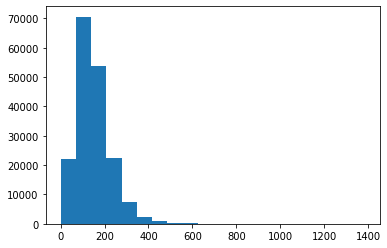

In [ ]:
plt.hist(char_lens, bins=20)

**Note:**

The difference betweeb how many words and how many characters given text contains:

**len(text)-** calculates how many characters the string contains (including spaces)

**len(text.split())-** calculate how many words the text contains. 
the default split argument in the split() function is " " thus it calculates words. 

*It can be change to calcule other segments in the text which separated by other character than " "

In [ ]:
sentence="ba ba ba"
len(sentence), len(sentence.split())

(8, 3)

In [ ]:
# Find what character length covers 95% of the data
output_seq_char_len=np.percentile(a=char_lens, q=95)

In [ ]:
# Gat all keyboard characters
import string
alphabet=string.ascii_lowercase+ string.digits+ string.punctuation
alphabet


'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer
NUM_CHAR_TOKENS=len(alphabet)+2 # add 2 for space and OOV/UNK token (OOV=out of vocab/Unkwon )
NUM_CHAR_TOKENS


char_vectorizer=TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                  output_sequence_length=int(output_seq_char_len),
                                  name="char_vectorizer")


In [ ]:
# Adapt character vectorizer to training characters 

char_vectorizer.adapt(train_chars)

In [ ]:
# Chack character vocab stats
char_vocab=char_vectorizer.get_vocabulary()
print(f"10 most frequent characters: {char_vocab[:10]}")
print(f"10 most rare charcters: {char_vocab[-5:]}")
vocab_size=char_vectorizer.vocabulary_size()
print(f"The character vocabulary size is {vocab_size}")
len(char_vocab)

10 most frequent characters: ['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's']
10 most rare charcters: ['k', 'x', 'z', 'q', 'j']
The character vocabulary size is 28


28

In [ ]:
# Test the character vectorizer 
random_train_chars=random.choice(train_chars)
print(f"char training text: {random_train_chars}")
print(f"length of random train chars: {len(random_train_chars.split())}")

vectorized_chars=char_vectorizer([random_train_chars])
print(f"\nVectorized chars\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

char training text: a t   b a s e l i n e   ,   s y m p t o m s   w e r e   w o r s e   i n   m e n   w i t h   d e p r e s s i o n   a n d   m i c r o v a s c u l a r   c o m p l i c a t i o n s   b u t   d i d   n o t   c o r r e l a t e   w i t h   t   l e v e l s   .
length of random train chars: 106

Vectorized chars
 [[ 5  3 22  5  9  2 12  4  6  2  9 19 15 14  3  7 15  9 20  2  8  2 20  7
   8  9  2  4  6 15  2  6 20  4  3 13 10  2 14  8  2  9  9  4  7  6  5  6
  10 15  4 11  8  7 21  5  9 11 16 12  5  8 11  7 15 14 12  4 11  5  3  4
   7  6  9 22 16  3 10  4 10  6  7  3 11  7  8  8  2 12  5  3  2 20  4  3
  13  3 12  2 21  2 12  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  

### Creating charcter-level embedding layer

In [ ]:
char_embed=layers.Embedding(input_dim=vocab_size,
                            output_dim=25,
                             mask_zero=False, # Use masking to handle variables with varying lengths
                             name="char_embed")

In [ ]:
# Test the character embedding layer
print(f"char text: {random_train_chars}")
print(f"vectorized text:\n {vectorized_chars}")

embedded_chars=char_embed(vectorized_chars)

print(f"Embedded text char-level:\n {embedded_chars}")
print(f"Char embedding shape: {embedded_chars.shape}")

char text: a t   b a s e l i n e   ,   s y m p t o m s   w e r e   w o r s e   i n   m e n   w i t h   d e p r e s s i o n   a n d   m i c r o v a s c u l a r   c o m p l i c a t i o n s   b u t   d i d   n o t   c o r r e l a t e   w i t h   t   l e v e l s   .
vectorized text:
 [[ 5  3 22  5  9  2 12  4  6  2  9 19 15 14  3  7 15  9 20  2  8  2 20  7
   8  9  2  4  6 15  2  6 20  4  3 13 10  2 14  8  2  9  9  4  7  6  5  6
  10 15  4 11  8  7 21  5  9 11 16 12  5  8 11  7 15 14 12  4 11  5  3  4
   7  6  9 22 16  3 10  4 10  6  7  3 11  7  8  8  2 12  5  3  2 20  4  3
  13  3 12  2 21  2 12  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

### Create datasets for char-level data for faster computational time

In [ ]:
# Turn char-level data into TEnsorFlow Dataset type:

train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot))
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot))
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot))

train_char_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:

# prefetch the data
train_char_dataset=train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Building the model

In [ ]:
# Build model 3

inputs=layers.Input(shape=(1,),dtype="string")
char_vectors=char_vectorizer(inputs)
char_embeddings=char_embed(char_vectors)

x=layers.Conv1D(filters=64,kernel_size=5,padding="same",activation="relu")(char_embeddings)
x=layers.GlobalMaxPool1D()(x)

outputs=layers.Dense(num_classes,activation="softmax")(x)

model_3=tf.keras.Model(inputs, outputs, name="model_3_conv1D_char_embedding")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()



Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_3 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_20 (Dense)            (None, 5

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2741 - accuracy: 0.4786 - val_loss: 1.0489 - val_accuracy: 0.5901
Epoch 2/3
562/562 [==============================] - 6s 10ms/step - loss: 1.0170 - accuracy: 0.5921 - val_loss: 0.9473 - val_accuracy: 0.6247
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.9361 - accuracy: 0.6356 - val_loss: 0.8750 - val_accuracy: 0.6576


In [ ]:
results_3=compare_results(model_3, val_data=val_char_dataset,val_labels=val_labels_encoded)

945/945 [==============================] - 3s 3ms/step - loss: 0.9386 - accuracy: 0.6331
[0.93857741355896, 0.6330597400665283]
{'accuracy': 63.30597113729644, 'precision': 0.6567946891512026, 'recall': 0.6330597113729644, 'f1': 0.6191230528305641}


In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.8931 - accuracy: 0.6538


[0.8930662274360657, 0.6537799835205078]

## Model 4: Combining pretrained token embeddings with character embeddings

Steps:

1. Create a pretrainde token embedding mdoel (similar to 'model_2').

2. Create a caharacter embedding model (similar to 'model_3' with slight modification)

3. Combaine 1 & 2 with a concatenate layer (layers.Concatenate)

4. Build a series of output layers on top of 3. simialar to figure 1 and section 4.2 of the paper:
https://arxiv.org/pdf/1612.05251.pdf

5. Constract a model which takes tokens and character-level sequences as an input and produced sequence label probabilities as an output

In [ ]:
# 1. Setup the tokens inputs/model
token_inputs=layers.Input(shape=[],dtype=tf.string, name="token_input")
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_outputs=layers.Dense(128,activation="relu")(token_embeddings)
token_model=tf.keras.Model(token_inputs,token_outputs)

# 2. Setup the cahracter-level inputs/model
char_inputs=layers.Input(shape=(1,),dtype="string", name="char_inputs")
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layer=layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(char_inputs,char_bi_lstm)

# 3. Concatenate token and char models (create a hybrid token embedding) 
token_char_concat=layers.Concatenate(name="token_char_hybrid")([token_model.output,char_model.output])

# 4. create output layers- adding Dropout, discussed in section 4.2 of the paper 
combined_dropout=layers.Dropout(0.5)(token_char_concat)
combined_dense=layers.Dense(128, activation="relu")(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Constract model with char and token inputs
model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],
                       outputs=output_layer,
                       name="model_4_token_and_char_embedings")

In [ ]:
# Get a summary of the model
model_4.summary()

Model: "model_4_token_and_char_embedings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['

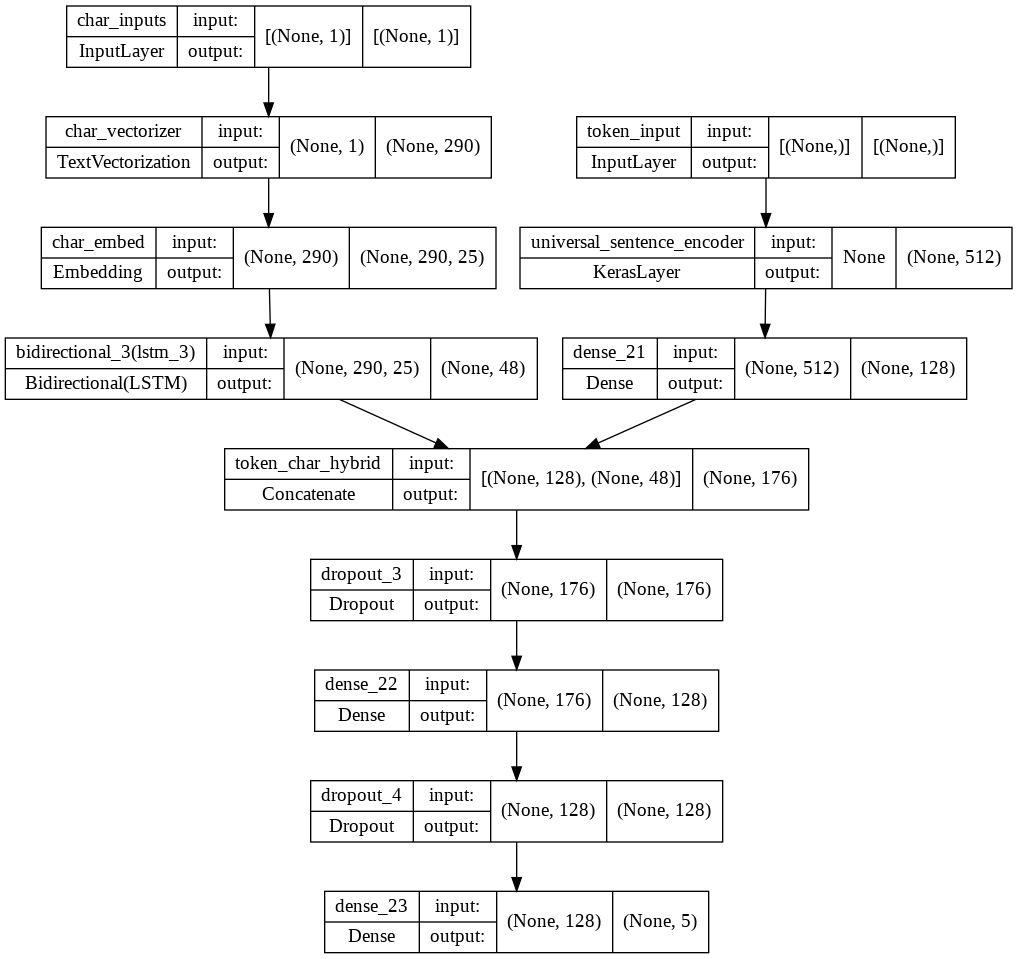

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Creating a Dataset pipeline which combines both token and char inputs

In [ ]:
#train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot))batch(32).prefetch(tf.data.AUTOTUNE)
# Create a combined token and char input dataset
train_char_token_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
train_char_token_labels=tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_dataset=tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset=train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Repeat the above steps for valiadation data
val_char_token_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
val_char_token_labels=tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_dataset=tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))

# Prefetch and batch train data
val_char_token_dataset=val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# CHeck the training and validation token and char embedding dataset
len(train_char_token_dataset), val_char_token_dataset

(5627,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

**Note:** It is important to present the combined datasets (in this case the token-char dataset) **in the same order** as it was presented to the model:
```
model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],
```

In this case the **token** inputs presented first, and it is in the same order in the combined dataset:
```
train_char_token_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
```

### Fit model 4 and compare the results

In [ ]:
# Fit model 4
history_4=model_4.fit(train_char_token_dataset,
            epochs=3,
            steps_per_epoch=int(0.1*len(train_char_token_dataset)),
            validation_data=(val_char_token_dataset),
            validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 34s 46ms/step - loss: 0.9781 - accuracy: 0.6120 - val_loss: 0.7832 - val_accuracy: 0.7028
Epoch 2/3
562/562 [==============================] - 29s 51ms/step - loss: 0.8070 - accuracy: 0.6881 - val_loss: 0.7254 - val_accuracy: 0.7221
Epoch 3/3
562/562 [==============================] - 23s 40ms/step - loss: 0.7779 - accuracy: 0.7022 - val_loss: 0.6975 - val_accuracy: 0.7324


In [ ]:
results_4=compare_results(model_4, val_data=val_char_token_dataset,val_labels=val_labels_encoded)

945/945 [==============================] - 17s 18ms/step - loss: 0.6969 - accuracy: 0.7331
[0.6969004273414612, 0.7330861687660217]
{'accuracy': 73.30861909175162, 'precision': 0.7339739922726018, 'recall': 0.7330861909175163, 'f1': 0.7305356596855421}


## Model 5- Transfer learning with pretrained token embedding + character embeddings + positional embeddings

### Extract the positional information (relative positin of line in the abstract) from the DataFrame

This is a type of feature engineering- incorporating non-obvious information about the data that wasn't avaliable before without processing. 

**Note:** When doing feature engineering it is important to cosider whether this infotmation will be availiable in the test data.

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_position=(train_df["line_number"]+1)/(train_df["total_lines"]+1)
train_position[:12]

0     0.083333
1     0.166667
2     0.250000
3     0.333333
4     0.416667
5     0.500000
6     0.583333
7     0.666667
8     0.750000
9     0.833333
10    0.916667
11    1.000000
dtype: float64

(array([4.5000e+04, 4.4941e+04, 4.2383e+04, 2.9914e+04, 1.2840e+04,
        3.8000e+03, 9.1000e+02, 2.0000e+02, 4.3000e+01, 9.0000e+00]),
 array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27., 30.]),
 <a list of 10 Patch objects>)

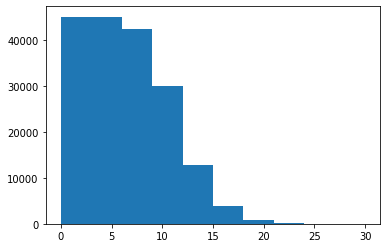

In [ ]:
# How many line numbers are there>
plt.hist(train_df["line_number"])

In [ ]:
train_df.line_number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

In [ ]:
# 95% of the lines are
line_number=np.percentile(train_df["line_number"], 95)
line_number

13.0

In [ ]:
# Use TensorFloe to create one-hot-encoded tensors of the 'line_numbers' feature
train_line_numbers_one_hot=tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:6], train_line_numbers_one_hot.shape, val_line_numbers_one_hot.shape, test_line_numbers_one_hot.shape

(<tf.Tensor: shape=(6, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]),
 TensorShape([30212, 15]),
 TensorShape([30135, 15]))

**Note:** At the end of this section try to use the relative position information ("train_position") instead of the one hot encoded during training and test the results.

(array([ 1393., 23102., 67507., 40551., 32807., 11026.,  2051.,  1223.,
          291.,    89.]),
 array([ 3. ,  5.7,  8.4, 11.1, 13.8, 16.5, 19.2, 21.9, 24.6, 27.3, 30. ]),
 <a list of 10 Patch objects>)

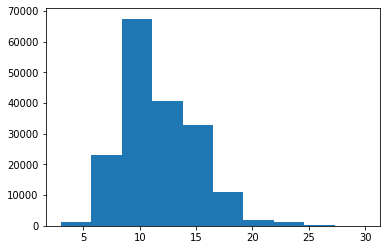

In [ ]:
# Explore the total lines parameter
plt.hist(train_df.total_lines)

In [ ]:
#95% of the total lines are:
total_lines=np.percentile(train_df["total_lines"], 95)
total_lines

18.0

In [ ]:
# One hot encoding of the total lines 
train_total_lines_one_hot=tf.one_hot(train_df.total_lines.to_numpy(), depth=20)
val_total_lines_one_hot=tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines=tf.one_hot(test_df.total_lines.to_numpy(), depth=20)
train_total_lines_one_hot[:5],train_total_lines_one_hot.shape, val_total_lines_one_hot.shape, test_total_lines.shape 

(<tf.Tensor: shape=(5, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.]], dtype=float32)>,
 TensorShape([180040, 20]),
 TensorShape([30212, 20]),
 TensorShape([30135, 20]))

### Building a trybrid embedding model

Steps:

1. Create a tolen level model
2. Create a character level model
3. Create a model for the 'line number' feature
4. Create a model for the total lines feature 
5. Combine the outputs of models 1 & 2 using tf.keras.layers.Concatenate
6. Combine 3, 4 & 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribride embedding and output label procabilities 
8. Combine the inputs of 1,2,3 & 4 and the outputs of 7 into tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs=layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_outputs=layers.Dense(128, activation="relu")(token_embeddings)
token_model=tf.keras.Model(token_inputs, token_outputs, name="token_model")

# 2. Create character level model
char_inputs=layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layer=layers.LSTM(24))(char_embeddings)
chaR_model=tf.keras.Model(char_inputs,char_bi_lstm, name="char_model")

# 5. Combine token and char embeddings
token_char_concat=layers.Concatenate(name="token_char_hybride")([token_model.output, char_model.output])
z=layers.Dense(256, activation="relu")(token_char_concat)
z=layers.Dropout(0.5)(z)


How to know which input shape we need?
Take the first raw of the data which will be input for the model. 
Example:

```
train_line_numbers_one_hot[0].shape
```

What stype should the input layer take?
Chack the dtype of the first raw in the input data:

```
train_line_numbers_one_hot.dtype
```

In [ ]:
train_line_numbers_one_hot[0].shape, train_line_numbers_one_hot[0].dtype

(TensorShape([15]), tf.float32)

In [ ]:
train_total_lines_one_hot[0].dtype

tf.float32

In [ ]:
# 3. Create model for line number feature
line_number_inputs=layers.Input(shape=(15,), dtype=tf.float32, name="line_number_inputs")
x=layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model=tf.keras.Model(line_number_inputs,x, name="line_number_model")


# 4. Create model for the total lines feature
total_lines_inputs=layers.Input(shape=(20,),dtype="float32", name="total_lines_inputs")
y=layers.Dense(32,activation="relu")(total_lines_inputs)
total_lines_model=tf.keras.Model(total_lines_inputs,
                                 y,
                                 name="total_lines_model")
#6. combine 3, 4 & 5:
trybrid_embeddings=layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output, 
                                                                               total_lines_model.output,
                                                                               z])





In [ ]:
# 7. Create output layer
output_layer=layers.Dense(num_classes,activation="softmax", name="output_layer")(trybrid_embeddings)

# 8. Make a keras model
model_5= tf.keras.Model(inputs=[line_number_model.input,
                                total_lines_model.input,
                                token_model.input,
                                char_model.input],
                        outputs=output_layer,
                        name="model_5_trybrid")

In [ ]:
# Get a summary of the trybrid model
model_5.summary()

Model: "model_5_trybrid"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0

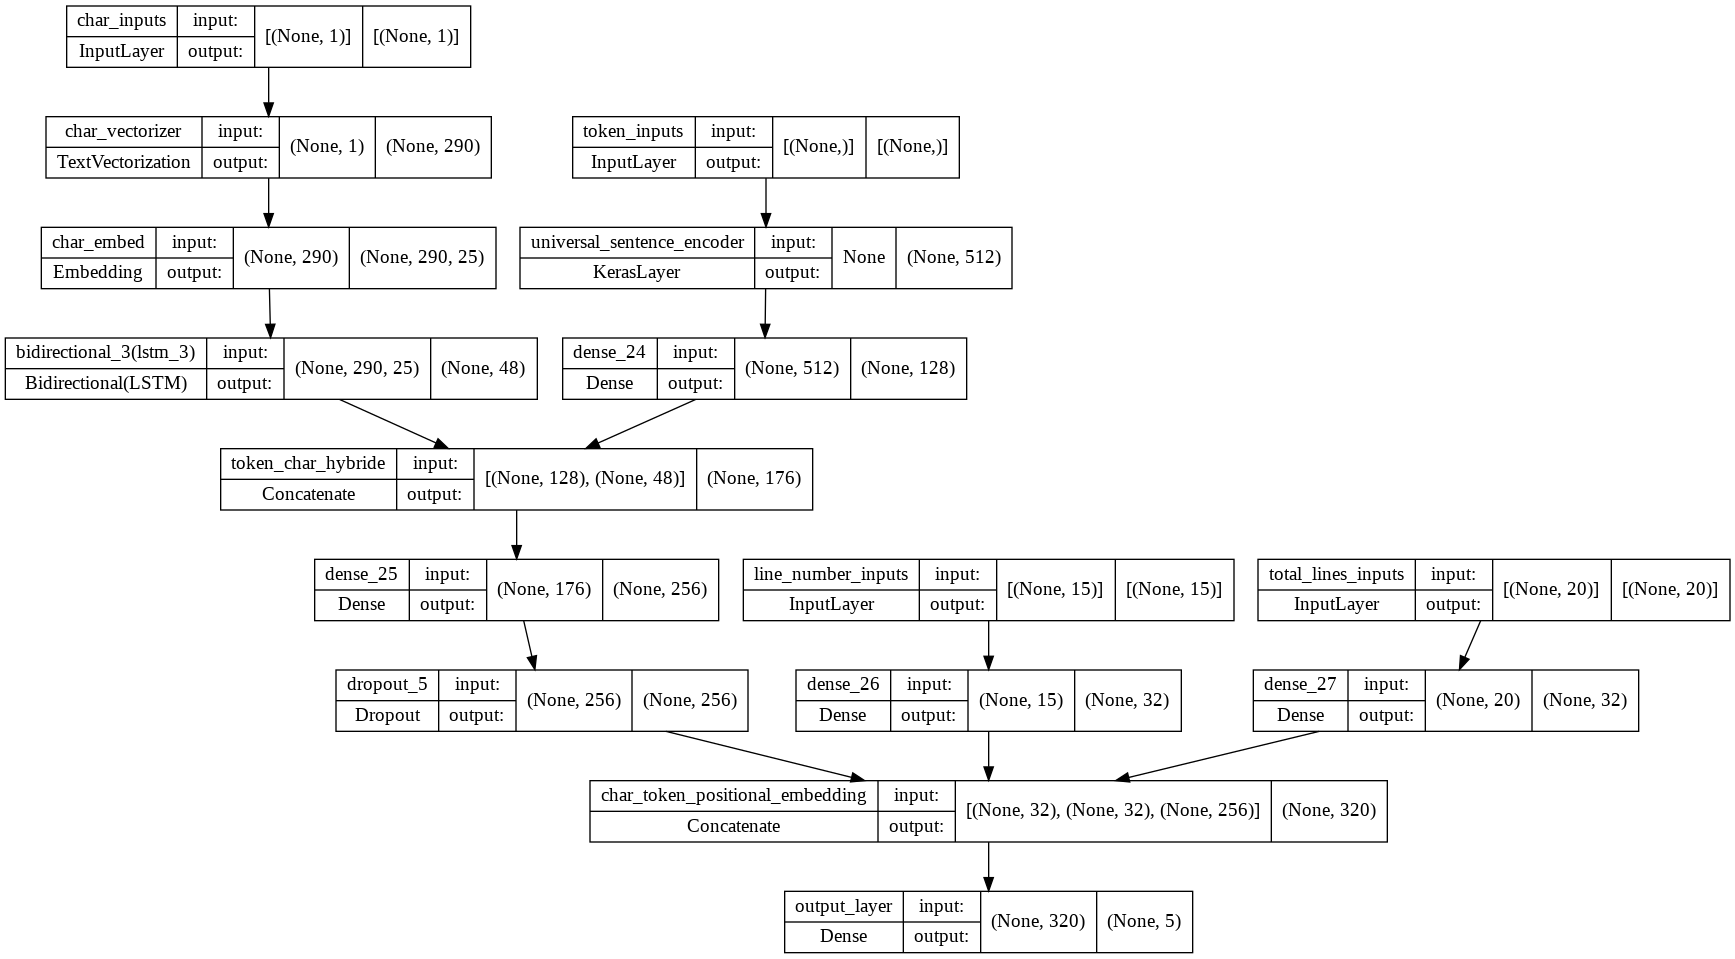

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothing?

For example, if the model gets too confident about one of the classes (i.e the prediction probability for this class will be really high) it may not consider other possible classes for this target.

Example for really confident prediction:
``` 
'[0.0, 0.0, 1.0, 0.0, 0.0]'
```
What label smoothing does is to assign some of the values from the highest pred prob to other classes. This should help the model improve generalization.

For example it can convert the above preditions into:
```
'[0.01, 0.01, 0.96, 0.01, 0.01]'
```

**Note:** Categorical crossentropy require the labels to be one-hot-encode. This is another reason  (in addition to the method **tf.data.Dataset** method that requires this) that we used one hot encoded data.

In [ ]:
# Compile model 5
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # Hekps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Create trybrid embedding Datasets using tf.data.Dateset method 

In [ ]:
'''train_line_dataset=tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot))
train_total_lines_dataset=tf.data.Dataset.from_tensor_slices((train_total_lines_one_hot))
train_line_dataset, train_total_lines_datase'''


In [ ]:
# The Dataset should be insetted in this order:
                            ''' line_number_model.input,
                                total_lines_model.input,
                                token_model.input,
                                char_model.input],'''

In [ ]:
# Creating training and validation Datasets with all 4 kinds of inputs
train_char_token_pos_data=tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                          train_total_lines_one_hot,
                                                          train_sentences,
                                                          train_chars))
train_char_token_pos_labels=tf.data.Dataset.from_tensor_slices((train_labels_one_hot))

# Zip the datasets together
train_char_token_pos_dataset=tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))

# Turn it into batches and prefetch it
train_char_token_pos_dataset=train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Same for validation dataset
val_char_token_pos_data=tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                          val_total_lines_one_hot,
                                                          val_sentences,
                                                          val_chars))
val_char_token_pos_labels=tf.data.Dataset.from_tensor_slices((val_labels_one_hot))

# Zip the datasets together
val_char_token_pos_dataset=tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))

# Turn it into batches and prefetch it
val_char_token_pos_dataset=val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
# Chack the Datasets chapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitiing evaluating and making preditions with the trybrid model

In [ ]:
history_5=model_5.fit(train_char_token_pos_dataset,
                      epochs=3,
                      steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                      validation_data=(val_char_token_pos_dataset),
                      validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 23s 34ms/step - loss: 1.0921 - accuracy: 0.7269 - val_loss: 0.9817 - val_accuracy: 0.8052
Epoch 2/3
562/562 [==============================] - 18s 32ms/step - loss: 0.9660 - accuracy: 0.8144 - val_loss: 0.9497 - val_accuracy: 0.8295
Epoch 3/3
562/562 [==============================] - 18s 32ms/step - loss: 0.9486 - accuracy: 0.8232 - val_loss: 0.9361 - val_accuracy: 0.8334


In [ ]:
results_5=compare_results(model_5, val_data=val_char_token_pos_dataset,val_labels=val_labels_encoded)
results_5

945/945 [==============================] - 17s 18ms/step - loss: 0.9354 - accuracy: 0.8328
[0.935370683670044, 0.8327816724777222]
{'accuracy': 83.27816761551702, 'precision': 0.831583483747044, 'recall': 0.8327816761551702, 'f1': 0.8315163413063412}


{'accuracy': 83.27816761551702,
 'f1': 0.8315163413063412,
 'precision': 0.831583483747044,
 'recall': 0.8327816761551702}

## Compare models results

In [ ]:
# Combine models results into a DataFrame
all_model_results=pd.DataFrame({"baseline": baseline_results,
                                "model_1": results_1,
                                "model_2": results_2,
                                "model_3": results_3,
                                "model_4": results_4,
                                "model_5": results_5})
all_model_results=all_model_results.transpose()

all_model_results

In [ ]:
# Reduce the accuracy to the same scale as the other metrucs
all_model_results["accuracy"]=all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline,0.721832,0.718647,0.721832,0.698925
model_1,0.788164,0.785335,0.788164,0.785744
model_2,0.713955,0.713930,0.713955,0.711036
model_3,0.633060,0.656795,0.633060,0.619123
model_4,0.733086,0.733974,0.733086,0.730536
model_5,0.832782,0.831583,0.832782,0.831516


Text(0, 0.5, 'Score')

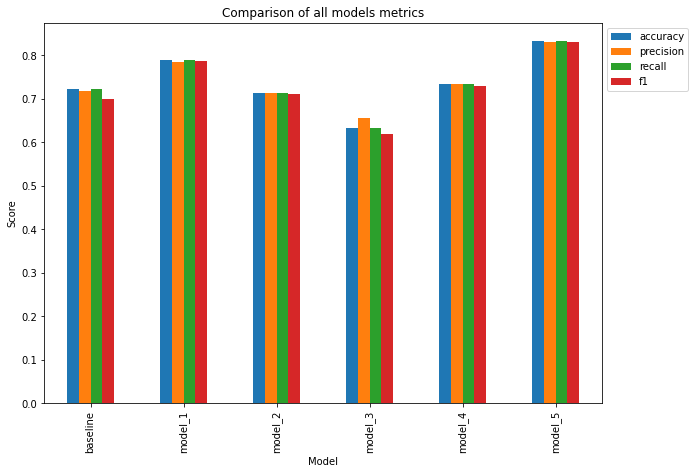

In [ ]:
# Plot and compare all models results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))
plt.title("Comparison of all models metrics")
plt.xlabel("Model")
plt.ylabel("Score")

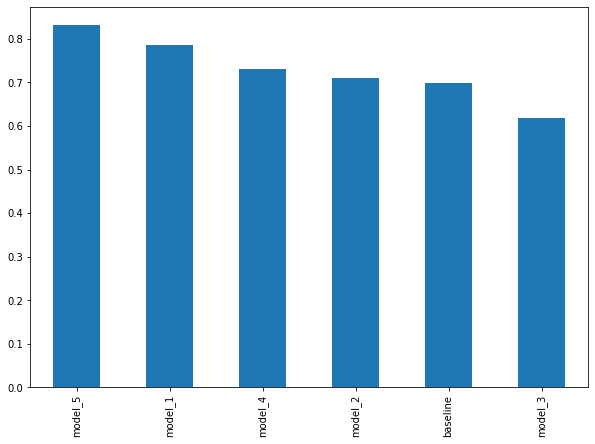

In [ ]:
# Sort models results by f1 score 
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7))

## Save and load a model

# Save a model
model_5.save("skimlit_trybrid_model")

In [ ]:
# Save the model
model_5.save("skimlit_trybrid_model")

In [ ]:
# How to download file from google colab to local machine
from google.colab import files
files.download("/content/skimlit_trybrid_model")

In [ ]:
# Load back the saved model
loaded_model=tf.keras.models.load_model("/content/skimlit_trybrid_model")

In [ ]:
# Make sure it is the same model by make predictions and compare them to the previous results
loaded_results=compare_results(loaded_model, val_char_token_pos_dataset, val_labels_encoded)

945/945 [==============================] - 18s 18ms/step - loss: 0.9354 - accuracy: 0.8328
[0.935370683670044, 0.8327816724777222]
{'accuracy': 83.27816761551702, 'precision': 0.831583483747044, 'recall': 0.8327816761551702, 'f1': 0.8315163413063412}


In [ ]:
results_5

{'accuracy': 83.27816761551702,
 'f1': 0.8315163413063412,
 'precision': 0.831583483747044,
 'recall': 0.8327816761551702}

# Download and load a pretrainde model ftom google storage 
To strat the challenges you can strat run the notebook from here.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip

!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2022-03-24 14:33:15--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.195.128, 2607:f8b0:400e:c05::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip.2’

skimlit_tribrid_mod 100%[===================>] 917.97M  95.0MB/s    in 6.3s    

2022-03-24 14:33:22 (146 MB/s) - ‘skimlit_tribrid_model.zip.2’ saved [962561955/962561955]

mkdir: cannot create directory ‘skimlit_gs_model’: File exists
Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-

# Challenges

## Challenge: merge the line numbers and total line to one positional featureMM

## Challenge: Model 6- combine the custom token embedding from model 1 with the trybrid model 5:

replace the pretrained token embedding layer in model 5 with the custom token embedding layer from model 1

## Challenge Model 7: Combine custom embedding from model 1 with positional embedding